# VIRAL Pneumonia 2D CNN classifier for X-Ray Images

<img src="https://storage.googleapis.com/kagglesdsdata/datasets/565888/1027538/NonAugmentedTrain/COVID-19/11.jpeg?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1587211731&Signature=QGEgclvqP%2FHUbhwqNEnrAcY%2Bp3OmubYxv%2BZgJ%2BVqKLwGugn%2FNPchIgWV%2FeRvbO%2BoeKjozgiFjXsT23xdxMA5O49%2FgwCyfFWKHckOCgWkS2QQwmSwOo7MMw0K8xwwP%2Bj1plBfNYHRAjjOVEWo9zPUwSlT8Nmoz%2FDCYWjxSZu21t8h2VeUqMw%2Bhy0aYPmsBtCMY9uVEh1Ar7qRQv%2FpwZjgtnGqD%2BaviAV06uU4dS0JP56orqmhs6Fc6vUGXA5830gflQWdNyKvGnMQ2xcz15NNKObRXYFfcuwh78i1V%2B3561A4F6pOD6N%2BFS0SS1L66zhKNg3vB5fYhYYcQo2WYZsaeQ%3D%3D"/>

<img width='20%' align='right' src='https://upload.wikimedia.org/wikipedia/fr/e/e0/Logo_CERN.jpg'/>

April 2020 <br>
Omar Zapata <b>CERN</b> <br>
Gerardo Gutierrez <b>UdeA</b> <br>

<b>Disclaimer:</b> this is an illustrative example using public dataset without clinical validation,
please use  this only for research or educational proposes.

This classifier is using kaggle dataset https://www.kaggle.com/darshan1504/covid19-detection-xray-dataset/data# <br>
NOTES for this dataset:
* different sizes
* different  number of channels
* annoations in the images (Arrows and Letters)

In [1]:
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import scipy
import skimage.io as io
from skimage.color import rgb2gray
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AveragePooling2D, Dropout,BatchNormalization,Activation,SpatialDropout2D
from tensorflow.keras.backend import set_session
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import backend as K

from sklearn.model_selection import train_test_split

# implementing the best metric to measure the performance of the prediction ofr me
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.utils import class_weight

/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
gpu_config = ConfigProto()
gpu_config.gpu_options.allow_growth = True
session = InteractiveSession(config=gpu_config)

# utility functions

In [3]:
def decode_img(img):
    img = io.imread(img)
    img = (img - np.mean(img))/np.std(img) #standarization  img-mean/std
    return img

def decode_valid_img(img,out_shape=(300,400)):
    '''
    validation dataset is not standarized, different sizes and number of channels in the images
    this function is stting it to 1 channela and size 300x400 like in the training dataset
    '''
    img = io.imread(img)
    img = rgb2gray(img)
    img = resize(img,out_shape)
    img = (img - np.mean(img))/np.std(img)
    
    return img




#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

# preprocessing data

**labels imgs**<br>
normal              = 0 <br>
viral pneumonia     = 1 <br>


# Training data

In [4]:
normal_imgs    = glob.glob('NonAugmentedTrain/Normal/*.jpeg')
viralpneu_imgs = glob.glob('NonAugmentedTrain/ViralPneumonia/*.jpeg')

y_train=[]
x_train=[]

for img in normal_imgs:
    x_train.append(decode_img(img))
    y_train.append(0)

for img in viralpneu_imgs:
    x_train.append(decode_img(img))
    y_train.append(1)

x_train=np.array(x_train).reshape((len(x_train),300,400,1))
print(x_train.shape)
print(len(y_train))

(1292, 300, 400, 1)
1292


# validation/test data

In [5]:
normal_imgs    = glob.glob('ValData/Normal/*.jpeg')
viralpneu_imgs = glob.glob('ValData/ViralPneumonia/*.jpeg')

y_valid=[]
x_valid=[]

for img in normal_imgs:
    x_valid.append(decode_valid_img(img))
    y_valid.append(0)


for img in viralpneu_imgs:
    x_valid.append(decode_valid_img(img))
    y_valid.append(1)

x_valid = np.array(x_valid).reshape((len(x_valid),300,400,1)) 

x_valid, x_test, y_valid, y_test = train_test_split(x_valid, y_valid, test_size=0.2, shuffle= True)

print(x_valid.shape)
print(len(y_valid))
print(x_test.shape)
print(len(y_test))

(524, 300, 400, 1)
524
(131, 300, 400, 1)
131


# Resume dataset

In [6]:
ones  = np.count_nonzero(y_train)
zeros = len(y_train) - np.count_nonzero(y_train)
initial_bias = np.log([ones/zeros])

#Nota importante, medimos los pesos antes de rebalancear, e igual se rebalancea para entrenar
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)


print('zeros = ',zeros)
print('ones  = ',ones)
print(class_weights)

class_weights2=[ones/len(y_train),zeros/len(y_train)]
print(class_weights2)

zeros =  880
ones  =  412
[0.73409091 1.56796117]
[0.3188854489164087, 0.6811145510835913]


In [7]:
metrics = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc')
]

model = Sequential()

loss=0

losses=['binary_crossentropy']
# I put a hard dropout here to avoid overffiting
sdropout = 0.2
dropout = 0.2
n_filter=2

model.add(Conv2D(2*n_filter, kernel_size=16, activation=tf.nn.relu, input_shape=(300,400,1)))
model.add(Conv2D(4*n_filter, kernel_size=8,use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2,2), strides=None, padding='valid', data_format=None))
model.add(SpatialDropout2D(sdropout))

model.add(Conv2D(4*n_filter, kernel_size=8,use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(SpatialDropout2D(sdropout))

model.add(Conv2D(8*n_filter, kernel_size=4,use_bias=False))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None))
model.add(SpatialDropout2D(sdropout))

model.add(Flatten())
model.add(Dense(256, activation=tf.nn.relu))
model.add(Dropout(dropout))
model.add(Dense(1, activation=tf.nn.sigmoid))

model.compile(optimizer=Adam(1e-5),
              loss=losses[loss],
              metrics=metrics)
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 285, 385, 4)       1028      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 278, 378, 8)       2048      
_________________________________________________________________
batch_normalization (BatchNo (None, 278, 378, 8)       32        
_________________________________________________________________
activation (Activation)      (None, 278, 378, 8)       0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 139, 189, 8)       0         
__________________________________________

In [8]:
epochs = 70
batch_size = 80
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), 
                    batch_size=batch_size, epochs=epochs)

Train on 1292 samples, validate on 524 samples
Epoch 1/70
1292/1292 [==============================] - 11s 9ms/sample - loss: 0.6604 - tp: 68.0000 - fp: 129.0000 - tn: 751.0000 - fn: 344.0000 - accuracy: 0.6339 - precision: 0.3452 - recall: 0.1650 - auc: 0.5899 - val_loss: 0.6793 - val_tp: 126.0000 - val_fp: 85.0000 - val_tn: 276.0000 - val_fn: 37.0000 - val_accuracy: 0.7672 - val_precision: 0.5972 - val_recall: 0.7730 - val_auc: 0.8299
Epoch 2/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.4534 - tp: 209.0000 - fp: 66.0000 - tn: 814.0000 - fn: 203.0000 - accuracy: 0.7918 - precision: 0.7600 - recall: 0.5073 - auc: 0.8490 - val_loss: 0.6674 - val_tp: 141.0000 - val_fp: 120.0000 - val_tn: 241.0000 - val_fn: 22.0000 - val_accuracy: 0.7290 - val_precision: 0.5402 - val_recall: 0.8650 - val_auc: 0.8629
Epoch 3/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.3712 - tp: 281.0000 - fp: 62.0000 - tn: 818.0000 - fn: 131.0000 - accuracy: 0.8506 - 

Epoch 22/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.1281 - tp: 372.0000 - fp: 25.0000 - tn: 855.0000 - fn: 40.0000 - accuracy: 0.9497 - precision: 0.9370 - recall: 0.9029 - auc: 0.9892 - val_loss: 0.2144 - val_tp: 143.0000 - val_fp: 15.0000 - val_tn: 346.0000 - val_fn: 20.0000 - val_accuracy: 0.9332 - val_precision: 0.9051 - val_recall: 0.8773 - val_auc: 0.9738
Epoch 23/70
1292/1292 [==============================] - 7s 6ms/sample - loss: 0.1205 - tp: 384.0000 - fp: 26.0000 - tn: 854.0000 - fn: 28.0000 - accuracy: 0.9582 - precision: 0.9366 - recall: 0.9320 - auc: 0.9900 - val_loss: 0.2010 - val_tp: 141.0000 - val_fp: 11.0000 - val_tn: 350.0000 - val_fn: 22.0000 - val_accuracy: 0.9370 - val_precision: 0.9276 - val_recall: 0.8650 - val_auc: 0.9753
Epoch 24/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0998 - tp: 392.0000 - fp: 23.0000 - tn: 857.0000 - fn: 20.0000 - accuracy: 0.9667 - precision: 0.9446 - recall: 0.9515 - auc: 0.9942 

Epoch 43/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0812 - tp: 391.0000 - fp: 16.0000 - tn: 864.0000 - fn: 21.0000 - accuracy: 0.9714 - precision: 0.9607 - recall: 0.9490 - auc: 0.9960 - val_loss: 0.1440 - val_tp: 144.0000 - val_fp: 8.0000 - val_tn: 353.0000 - val_fn: 19.0000 - val_accuracy: 0.9485 - val_precision: 0.9474 - val_recall: 0.8834 - val_auc: 0.9852
Epoch 44/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0699 - tp: 397.0000 - fp: 12.0000 - tn: 868.0000 - fn: 15.0000 - accuracy: 0.9791 - precision: 0.9707 - recall: 0.9636 - auc: 0.9977 - val_loss: 0.1491 - val_tp: 142.0000 - val_fp: 8.0000 - val_tn: 353.0000 - val_fn: 21.0000 - val_accuracy: 0.9447 - val_precision: 0.9467 - val_recall: 0.8712 - val_auc: 0.9834
Epoch 45/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0651 - tp: 398.0000 - fp: 13.0000 - tn: 867.0000 - fn: 14.0000 - accuracy: 0.9791 - precision: 0.9684 - recall: 0.9660 - auc: 0.9979 - 

Epoch 64/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0478 - tp: 405.0000 - fp: 12.0000 - tn: 868.0000 - fn: 7.0000 - accuracy: 0.9853 - precision: 0.9712 - recall: 0.9830 - auc: 0.9990 - val_loss: 0.1567 - val_tp: 142.0000 - val_fp: 7.0000 - val_tn: 354.0000 - val_fn: 21.0000 - val_accuracy: 0.9466 - val_precision: 0.9530 - val_recall: 0.8712 - val_auc: 0.9814
Epoch 65/70
1292/1292 [==============================] - 7s 6ms/sample - loss: 0.0583 - tp: 403.0000 - fp: 13.0000 - tn: 867.0000 - fn: 9.0000 - accuracy: 0.9830 - precision: 0.9688 - recall: 0.9782 - auc: 0.9982 - val_loss: 0.1539 - val_tp: 144.0000 - val_fp: 8.0000 - val_tn: 353.0000 - val_fn: 19.0000 - val_accuracy: 0.9485 - val_precision: 0.9474 - val_recall: 0.8834 - val_auc: 0.9811
Epoch 66/70
1292/1292 [==============================] - 7s 5ms/sample - loss: 0.0603 - tp: 400.0000 - fp: 10.0000 - tn: 870.0000 - fn: 12.0000 - accuracy: 0.9830 - precision: 0.9756 - recall: 0.9709 - auc: 0.9976 - va

dict_keys(['loss', 'tp', 'fp', 'tn', 'fn', 'accuracy', 'precision', 'recall', 'auc', 'val_loss', 'val_tp', 'val_fp', 'val_tn', 'val_fn', 'val_accuracy', 'val_precision', 'val_recall', 'val_auc'])


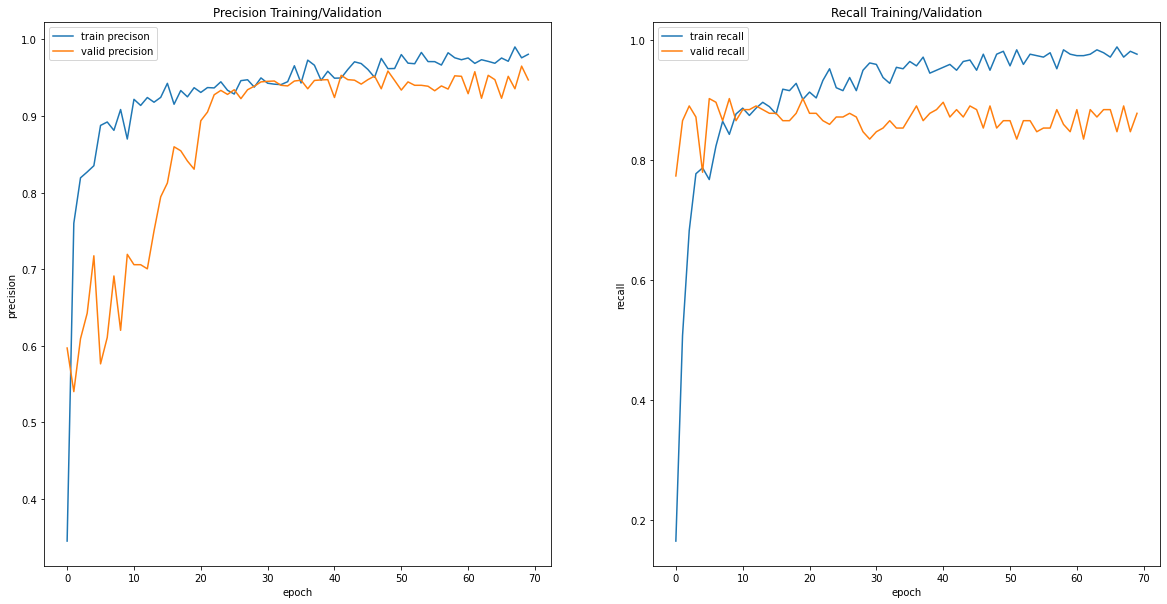

In [9]:
# list all data in history
print(history.history.keys())
fig = plt.figure(figsize=(20,10))
plt.gray()  # show the filtered result in grayscale
ax1 = fig.add_subplot(121)  # left side
ax2 = fig.add_subplot(122)  # right side

ax1.set_title('Precision Training/Validation')
ax2.set_title('Recall Training/Validation')

# summarize history for accuracy
ax1.plot(history.history['precision'])
ax1.plot(history.history['val_precision'])
ax2.plot(history.history['recall'])
ax2.plot(history.history['val_recall'])
#ax1.title('model accuracy')
ax1.set_xlabel('epoch')
ax1.set_ylabel('precision')

ax2.set_xlabel('epoch')
ax2.set_ylabel('recall')

ax1.legend(['train precison', 'valid precision'], loc='upper left')
ax2.legend(['train recall','valid recall'], loc='upper left')

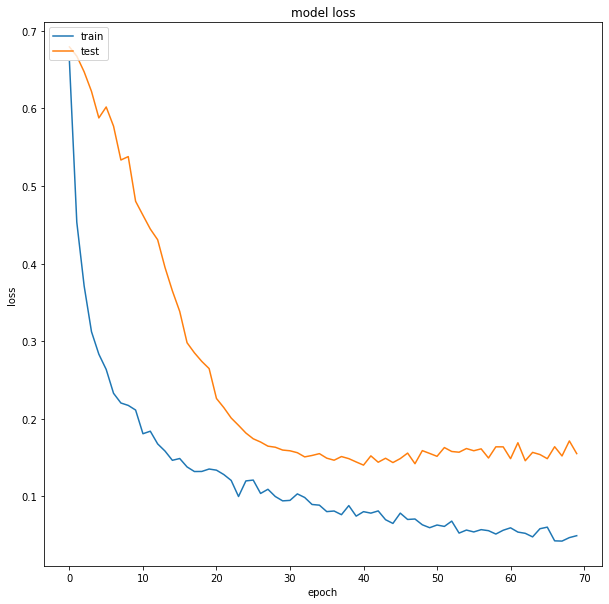

In [10]:
# summarize history for loss
fig = plt.figure(figsize=(10,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
y_pred_keras = model.predict(x_test).ravel()
print(y_pred_keras.shape)
print(len(y_test))

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

(131,)
131


In [12]:
auc_keras = auc(fpr_keras, tpr_keras)

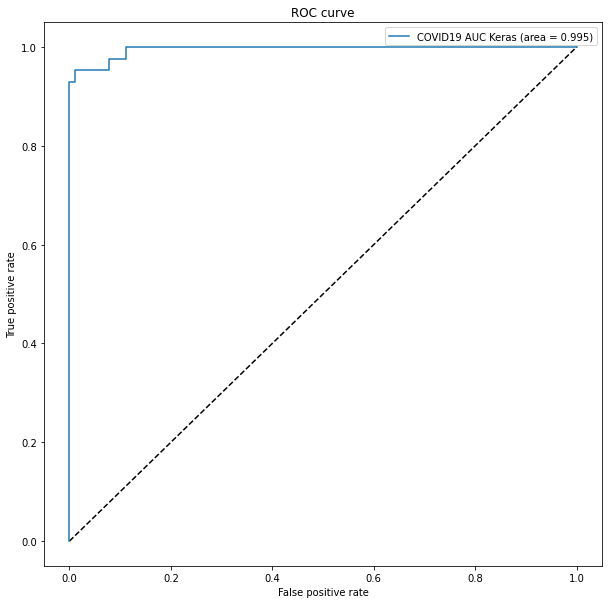

In [13]:
fig = plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='COVID19 AUC Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [14]:
y_pred_keras_category = model.predict_classes(x_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_keras_category).ravel()
print(tn, fp, fn, tp)

87 2 2 40


In [15]:
plot_confusion_matrix(cm           = confusion_matrix(y_test, y_pred_keras_category), 
                      normalize    = False,
                      target_names = ['healty', 'Viral pneumonia'],
                      title        = "Confusion Matrix")